In [1]:
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



import warnings
warnings.filterwarnings('ignore')

C:\Users\mussa\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df= pd.read_csv('Final.csv')
df.head()

,index,id,headline,written_by,news,label,cleaned_news,Length,Cleaned_length,cleaned_headline,cleaned_by,word_count_n,word_count_cn
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,washington sonny perdue telling georgian growi...,7936,5255,ethics questions dogged agriculture nominee as...,eric lipton and steve eder,1342,724
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,houston venezuela plan tactical approach desig...,6112,3948,u.s. must dig deep to stop argentina’s lionel ...,david waldstein,1050,575
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,sunday abc week discussing republican plan rep...,425,275,cotton to house: ’do not walk the plank and vo...,pam key,80,42
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,augusta beleaguered republican governor maine ...,6516,4334,"paul lepage, besieged maine governor, sends co...",jess bidgood,1103,592
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,finian cunningham written extensively internat...,9164,6522,a digital 9/11 if trump wins,finian cunningham,1442,859


## Combining 'Headline', 'News', 'Written by' for better accuracy

In [3]:
X = df['cleaned_headline'] + '  ' + df['cleaned_news'] + '  ' + df['cleaned_by']
y = df['label']

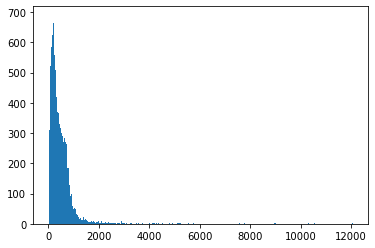

In [4]:
plt.hist([len(x.split()) for x in X], bins = 700);

In [5]:
#maximum length in train dataset 
max_length = X.map(lambda x: len(x.split())).max()
max_length                   

12076

## Tokenization and padding

In [6]:
vocab_size = 10000

#fit tokenizer
tok = Tokenizer(num_words = vocab_size)
tok.fit_on_texts(X)

#tokenize data
X = tok.texts_to_sequences(X)

#Pad data
X = pad_sequences(X, maxlen = max_length, padding= 'pre' )

## Building model

In [7]:
model = Sequential([
        Embedding(vocab_size, output_dim=100, input_length=max_length),
        LSTM(units=128, return_sequences=True),
        LSTM(units=64, return_sequences=True),
        GlobalMaxPooling1D(),
        Dense(units=64),
        Dropout(0.25),
        Dense(units=16),
        Dropout(0.25),
        Dense(units = 8),
        Dropout(0.25),
        Dense(units=1, activation='sigmoid')
    ])

model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12076, 100)        1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 12076, 128)        117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12076, 64)         49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1

## Fitting model

In [9]:
import numpy as np

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2)

In [12]:
X_train.shape

(16106, 12076)

In [13]:
model.fit(X_train,
         y_train,
         epochs = 5,
         validation_data= (X_test, y_test),
         batch_size = 16,
         verbose = True)

Epoch 1/5
1007/1007 [==============================] - 919s 906ms/step - loss: 0.2100 - accuracy: 0.9133 - val_loss: 0.0691 - val_accuracy: 0.9809
Epoch 2/5
1007/1007 [==============================] - 908s 902ms/step - loss: 0.0461 - accuracy: 0.9868 - val_loss: 0.0511 - val_accuracy: 0.9844
Epoch 3/5
1007/1007 [==============================] - 912s 906ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.0862 - val_accuracy: 0.9811
Epoch 4/5
1007/1007 [==============================] - 909s 903ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0571 - val_accuracy: 0.9846
Epoch 5/5
1007/1007 [==============================] - 933s 927ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0620 - val_accuracy: 0.9866


In [14]:
y_pred = (model.predict(X_test)>= 0.5).astype('int')

In [15]:
print(y_pred)

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


In [16]:
y_test

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2049
           1       0.98      0.99      0.99      1978

    accuracy                           0.99      4027
   macro avg       0.99      0.99      0.99      4027
weighted avg       0.99      0.99      0.99      4027



In [19]:
from sklearn.metrics import confusion_matrix, plot_roc_curve

In [20]:
print(confusion_matrix(y_test, y_pred))

[[2012   37]
 [  17 1961]]


In [21]:
model.save('model.h5')